# Distribución geográfica de causas judiciales CABA - ODSLA - Desafío 1

## Introducción

Este notebook forma parte del Desafío ODSLA 1. El objetivo del desafío es distribuir de forma más equitativa las tareas entre los distintos juzgados del fuero Penal, Contravencional y de Faltas de la Ciudad Autónoma de Buenos Aires. Al hacerlo deberán tener en cuenta: Minimizar la distancia del juzgado con el lugar donde ocurre el hecho (lat/lon) Evitar discrecionalidades ni pasos “manuales” en la asignación de las causas, idealmente tener en cuenta los tiempos de procesamiento de los distintos delitos (artículo y tiempo del expediente) a fin de intentar que la distribución de las tareas más duras también sea proporcional.

En este notebook se exploran varios aspectos de la base de datos correspondiente en función de la distribución geográfica de los data points.

## Librerías y dataset

In [1]:
import time
time_init = time.time()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('penal_df.xlsx')

In [4]:
df.head()

,org_idradactual,exp_cuij,org_idintpri,org_cod_pri,org_descorta_pri,org_descr_Pri,org_idintseg,est_id,est_descr,exp_anio,...,den_v_domestica,den_v_genero,den_zon_id,den_zona,filter_.,org_destino_act,PrimarioDen_id,PrimarioDen_id_oju,PrimarioExp_id,PrimarioExp_oju
0,72,01-00042685-3,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,1,ASIGNADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
1,72,01-00039012-3,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,14,ARCHIVADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
2,72,01-00035028-8,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,1,ASIGNADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
3,72,01-00036824-1,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,14,ARCHIVADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1
4,72,01-00034124-6,72,JUZP01,JUZGADO N°1,JUZGADO DE 1RA INSTANCIA EN LO PENAL CONTRAVEN...,unknown,14,ARCHIVADO,2016,...,NaN,NaN,unknown,unknown,1,unknown,1,1,1,1


In [5]:
df.columns

Index(['org_idradactual', 'exp_cuij', 'org_idintpri', 'org_cod_pri',
       'org_descorta_pri', 'org_descr_Pri', 'org_idintseg', 'est_id',
       'est_descr', 'exp_anio', 'exp_cuerpos', 'exp_fojas', 'exp_detenidos',
       'exp_id', 'exp_sufijo', 'exp_fechecho', 'exp_fecinidem', 'exp_fecini',
       'exp_fecreg', 'exp_fecsor', 'exp_fecelev', 'exp_letra', 'oju_id',
       'oju_descr', 'exp_ultmov', 'exp_ultmovf', 'den_id', 'den_cod_casoMPF',
       'Tipo_ingreso_MPF', 'org_cod', 'org_descr', 'org_descorta', 'org_den',
       'org_descorta_Den', 'org_descr_Den', 'den_flagrante', 'Comuna',
       'den_barrio', 'den_calle_id', 'den_cod_postal', 'den_fec_hecho',
       'den_fec_ingreso_MPF', 'den_fec_ini_comi', 'den_hora_hecho',
       'den_latitud', 'den_longitud', 'den_tipo_den', 'den_loc_id',
       'den_sin_lugar_hecho', 'den_v_domestica', 'den_v_genero', 'den_zon_id',
       'den_zona', 'filter_.', 'org_destino_act', 'PrimarioDen_id',
       'PrimarioDen_id_oju', 'PrimarioExp_id', 'Pri

### Mapas: Barrios y Comunas

En este apartado generamos el mapa de las Zonas Judiciales con información de <b>BA Data</b> (archivos .csv con coordenadas de barrios y detalle de Comunas). Usamos las librerías geopandas y Shapely.

In [6]:
import geopandas as gpd
map_df = gpd.read_file('barrios.csv')
map_df.columns

Index(['WKT', 'barrio', 'comuna', 'perimetro', 'area', 'geometry'], dtype='object')

In [7]:
map_df[['barrio','geometry','comuna']].head()

,barrio,geometry,comuna
0,CHACARITA,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5...",15
1,PATERNAL,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5...",15
2,VILLA CRESPO,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5...",15
3,VILLA DEL PARQUE,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6...",11
4,ALMAGRO,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6...",5


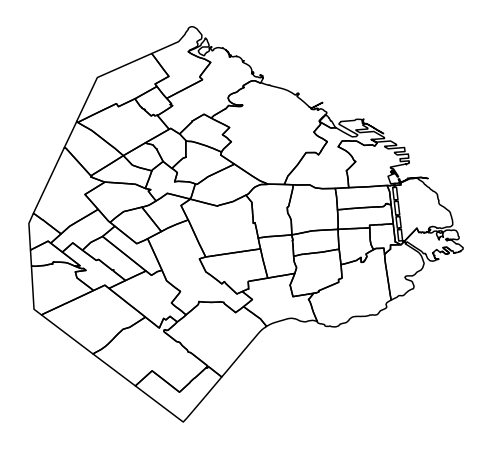

In [8]:
fig, ax = plt.subplots(1, figsize=(10, 8))
map_df.boundary.plot(ax=ax,edgecolor='0')
ax.axis('off')
plt.show()

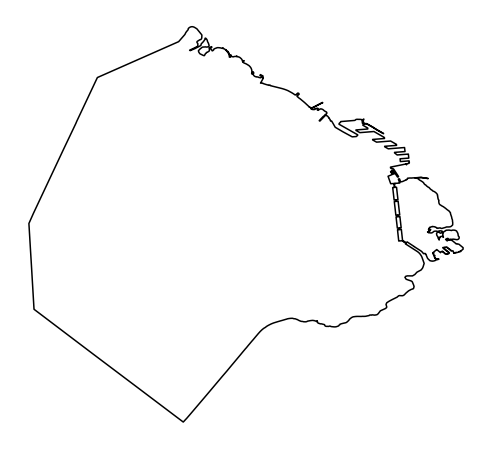

In [9]:
# Mapa de CABA
from shapely.ops import unary_union
polygons = [map_df.at[i,'geometry'] for i in range(map_df.shape[0])]
caba_polygon = unary_union(polygons)
caba_df = gpd.GeoDataFrame()
caba_df['geometry'] = [caba_polygon]
# Pequeña correcion a la geometría
epsilon = 10**(-12)
caba_df['geometry'] = caba_df['geometry'].map(lambda x:x.buffer(epsilon).buffer(-epsilon))
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.boundary.plot(ax=ax,edgecolor='0')
ax.axis('off')
plt.show()

## Geolocalización de causas

### Feature Engineering

Hay varias columnas que refieren a información geográfica. La dificultad es que (1) presentan muchos NaNs y que (2) son datos de diferente naturaleza. La idea de este apartado es convertir los datos, cuando sea posible, en latitudes y longitudes.

In [10]:
df_dict = pd.read_excel('diccionario de datos ingresos a juzg.xlsx',
                       header=0)
df_dict.keys()

Index(['Variables ', 'Definición'], dtype='object')

### Dataset a utilizar

Utilizo un df que contenga solamente las causas con coordenadas. Reseteo los índices, pero me quedo los originales por si necesito comparar con mi df original. Todas las inferencias geográficas que podamos hacer dependerán del proceso generador de las coordenadas NaNs, de modo que en un apartado posterior lo exploramos con algún detalle.  

In [11]:
# convierto 'unknown' en NaN para contabilizar
import itertools as it
for i, col in it.product(df.index,df.columns):
    if df.at[i,col] == 'unknown':
        df.at[i,col] = np.nan

In [12]:
geo_df = df[df['den_latitud'].notna()]
geo_df = geo_df.reset_index()
geo_df.loc[:,['den_latitud','den_longitud']].head()

,den_latitud,den_longitud
0,-58.48,-34.62
1,-58.51,-34.67
2,-58.44,-34.67
3,-58.44,-34.67
4,-58.36,-34.63


In [13]:
geo_df.shape

(11119, 60)

In [14]:
df[['den_latitud','den_longitud']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37136 entries, 0 to 37135
Data columns (total 2 columns):
den_latitud     11119 non-null object
den_longitud    11119 non-null object
dtypes: object(2)
memory usage: 580.4+ KB


In [15]:
# Convierto coordenadas a float (ahora son object)
try:
    geo_df['den_latitud'] = geo_df['den_latitud'].apply(lambda x: float(x))
    geo_df['den_longitud'] = geo_df['den_longitud'].apply(lambda x: float(x))
except:
    print('Cannot convert')

### Imprecisión en las coordenadas

El dataset contiene un alto grado de imprecisión en las coordenadas geográficas, que se han truncado a dos decimales. <b>(Ese fue mi entendimiento en la conversación con el juez Pablo Casas, habría que chequear que estén truncadas y no redondeadas; en lo que sigue trabajo con ese supuesto, con una pequeña correción podría transformarse al caso de redondeo).</b> 

Para poder visualizar contemplando esta imprecisión, a cada causa le asigno un polígono que contemple el truncamiento. Por ejemplo, si <b>den_latitud</b> es -58.48, podría ir de -58.4800 a -58.4899 (haremos -58.49). Entonces defino una función que genere un polígono contamplando esta amplitud. A cada "punto" del dataset la función le asignará un cuadrado que vaya entre sus posibles valores. Por ejemplo, al punto (-58.48,-34.62) le asignará el cuadrado con coordenadas (-58.48,-34.62), (-58.48,-34.63), (-58.49,-34.63), (-58.49,-34.62) (ver ejemplo gráfico en mapa).

In [16]:
from shapely.geometry import Point, Polygon
def point_to_poly(lat, lon):
    poly = Polygon([(lat,lon),(lat,lon-0.01),(lat-0.01,lon-0.01),(lat-0.01,lon)])
    return poly

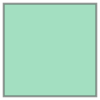

In [17]:
point_to_poly(-58.48,-34.62)

Me gustaría ver qué grado de incertidumbre implica esta información. Vamos a medir cada lado del cuadrado con una aproximación euclideana.

In [18]:
def distance(lon1,lat1,lon2,lat2):
    # Longitud aprox de meridianos / paralelos en metros
    deglen = 110500
    delta_x = lat1 - lat2
    delta_y = (lon1 - lon2)*np.cos((lat1 + lat2) / 2)
    return deglen*((delta_x)**2 + (delta_y)**2)**(0.5)

print(f'Distancia de un lado (aprox): {round(distance(-58.48,-34.62,-58.48,-34.63))} m')

Distancia de un lado (aprox): 1105.0 m


Es decir, es un cuadrado de aproximadamente 1100 de largo.

In [19]:
# Construcción de geometry para geopandas
geometry = []
for i in range(geo_df.shape[0]):
    lat = geo_df.at[i,'den_latitud']
    lon = geo_df.at[i,'den_longitud']
    geometry.append(point_to_poly(lat,lon).intersection(caba_polygon))
geo_df = gpd.GeoDataFrame(geo_df,geometry=geometry)

### Errores

Vamos a limpiar el dataset de errores: hay coordenadas que no corresponden a CABA.

In [20]:
# Chequeo los que tengan intersección nula
cuenta = 0
for i in range(geo_df.shape[0]):
    if geo_df.loc[i,'geometry'].is_empty:
        cuenta += 1
        geo_df.drop(i,inplace=True)
geo_df = geo_df.reset_index(drop=True)
print(f'Se removieron {cuenta} instancias con error.')

Se removieron 1019 instancias con error.


### Agrupación por zona y ploteo

La información así organizada nos divide a la Ciudad de Buenos Aires en una grilla de cuadrículas geográficas que estudiaremos a lo largo de este notebook. A continuación usamos los polígonos generados como variable de agrupamiento, para así calcular índices representativos de la distribución geográfica. Empezamos por la cantidad de casos.

In [21]:
from shapely import wkt

geo_df_pd = pd.DataFrame(geo_df)
for i in range(geo_df_pd.shape[0]):
    geo_df_pd.at[i,'str_geometry'] = str(geo_df_pd.at[i,'geometry'])
casos_geometry = geo_df_pd['str_geometry'].value_counts()
casos_geometry = casos_geometry.to_frame().reset_index(drop=False)
casos_geometry = casos_geometry.rename(columns={'index':'polygon','str_geometry':'casos'})
casos_geo_df = gpd.GeoDataFrame(casos_geometry['casos'], 
                                geometry=casos_geometry['polygon'].apply(wkt.loads))
casos_geo_df.head()

,casos,geometry
0,199,"POLYGON ((-58.39000 -34.60000, -58.39000 -34.6..."
1,184,"POLYGON ((-58.38000 -34.60000, -58.38000 -34.6..."
2,170,"POLYGON ((-58.41000 -34.61000, -58.41000 -34.6..."
3,153,"POLYGON ((-58.41000 -34.62000, -58.41000 -34.6..."
4,152,"POLYGON ((-58.39000 -34.61000, -58.39000 -34.6..."


In [22]:
casos_geo_df.shape

(210, 2)

In [23]:
casos_geo_df['coords'] = casos_geo_df['geometry'].apply(lambda x: x.representative_point().coords[:])
casos_geo_df['coords'] = [coords[0] for coords in casos_geo_df['coords']]
casos_geo_df.head()

,casos,geometry,coords
0,199,"POLYGON ((-58.39000 -34.60000, -58.39000 -34.6...","(-58.394999999999996, -34.605000000000004)"
1,184,"POLYGON ((-58.38000 -34.60000, -58.38000 -34.6...","(-58.385000000000005, -34.605000000000004)"
2,170,"POLYGON ((-58.41000 -34.61000, -58.41000 -34.6...","(-58.41499999999999, -34.614999999999995)"
3,153,"POLYGON ((-58.41000 -34.62000, -58.41000 -34.6...","(-58.41499999999999, -34.625)"
4,152,"POLYGON ((-58.39000 -34.61000, -58.39000 -34.6...","(-58.394999999999996, -34.614999999999995)"


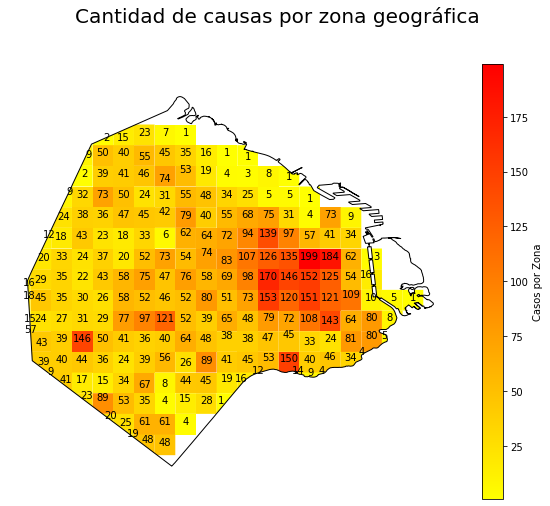

In [24]:
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.plot(linewidth=1, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                  legend_kwds={'label': "Casos por Zona",})
# Labeleo el nombre a cada comuna
for idx, row in casos_geo_df.iterrows():
    plt.annotate(s=row['casos'], xy=row['coords'],
                 horizontalalignment='center')
fig.suptitle('Cantidad de causas por zona geográfica',size=20)
ax.axis('off')
plt.savefig('Causas_por_zona.png')
plt.show()

Este heatmap nos da una idea general de donde hay mayor densidad de causas (notar que coincide con las conclusiones del apartado "Comparación entre Zonas judiciales"). La otra pregunta interesante con estos datos es el tamaño promedio de las causas (vinculada con la "carga de trabajo").

### Fojas promedio por Zona geográfica

A continuación realizamos un análisis similar para la cantidad de fojas, excluyendo las causas con una foja que según comentó Yasmin Quiroga, se deben a un error en la carga de datos (i.e., lo interpretamos como un NaN). 

In [25]:
geo_df_fojas = geo_df[geo_df.exp_fojas > 1]

In [26]:
fojas_median_geometry = geo_df_fojas.groupby('str_geometry').median()['exp_fojas']
fojas_median_geometry = fojas_median_geometry.to_frame().reset_index(drop=False)
fojas_median_geo_df = gpd.GeoDataFrame(fojas_median_geometry['exp_fojas'], 
                                     geometry=fojas_median_geometry['str_geometry'].apply(wkt.loads))
fojas_median_geo_df.head()

,exp_fojas,geometry
0,28.5,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000..."
1,154.0,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000..."
2,76.0,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000..."
3,66.0,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000..."
4,49.0,"POLYGON ((-58.36000 -34.61000, -58.36000 -34.6..."


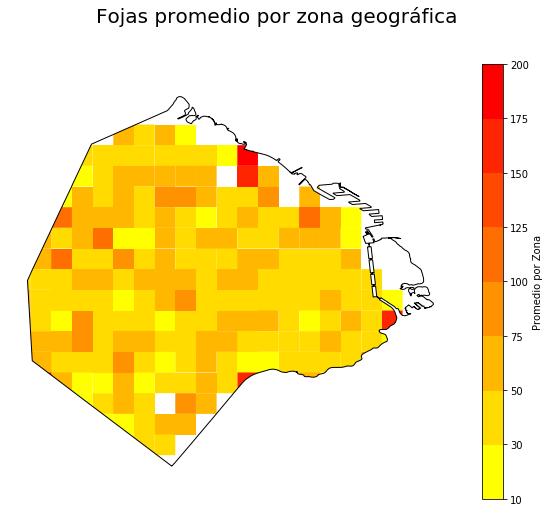

In [27]:
import matplotlib.colors as colors

fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.plot(linewidth=1, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
bounds = np.array([10,30,50,75,100,125,150,175,200,])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fojas_median_geo_df.plot(ax=ax,column='exp_fojas',zorder=1,
                         legend=True,cmap='autumn_r',norm=norm,
                        legend_kwds={'label': "Promedio por Zona",})

fig.suptitle('Fojas promedio por zona geográfica',size=20)
ax.axis('off')
plt.show()

Podríamos investigar los valores grandes en detalle como parte de nuestro entendimiento del problema de la "carga de trabajo" (a lo mejor me están indicando algo valioso). Por lo demás, la conclusión es que el tamaño de las causas es bastante uniforme geográficamente, con lo cual la cantidad de causas es una variable mucho más relevante a la hora de la distribución geográfica. A su vez, pareciera haber una leve correlación negativa entre el tamaño promedio de las causas y su cantidad en cada cuadrícula. Veamos.

### Correlación entre cantidad de casos y fojas promedio

In [28]:
merge_df = fojas_median_geo_df.merge(casos_geo_df,on='geometry')
merge_df.head()

,exp_fojas,geometry,casos,coords
0,28.5,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000...",5,"(-58.354294088366956, -34.62506061114897)"
1,154.0,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000...",8,"(-58.35655385118322, -34.63466414848245)"
2,76.0,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000...",4,"(-58.3697100558266, -34.65118001337335)"
3,66.0,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000...",1,"(-58.394999999999996, -34.57686555016434)"
4,49.0,"POLYGON ((-58.36000 -34.61000, -58.36000 -34.6...",16,"(-58.36765813123695, -34.61386353121595)"


In [29]:
merge_df[['exp_fojas','casos']].corr()

,exp_fojas,casos
exp_fojas,1.000000,-0.184404
casos,-0.184404,1.000000


In [30]:
from scipy.stats import pearsonr

results = pearsonr(merge_df['exp_fojas'],merge_df['casos'])
print(f'Coeficiente de correlación de Pearson: ',results[0])
p = results[1]
print(f'p-value: ',results[1])
if p < 0.05:
    print('Correlación significativa al 5%')

Coeficiente de correlación de Pearson:  -0.18440434769027264
p-value:  0.008609505109992184
Correlación significativa al 5%


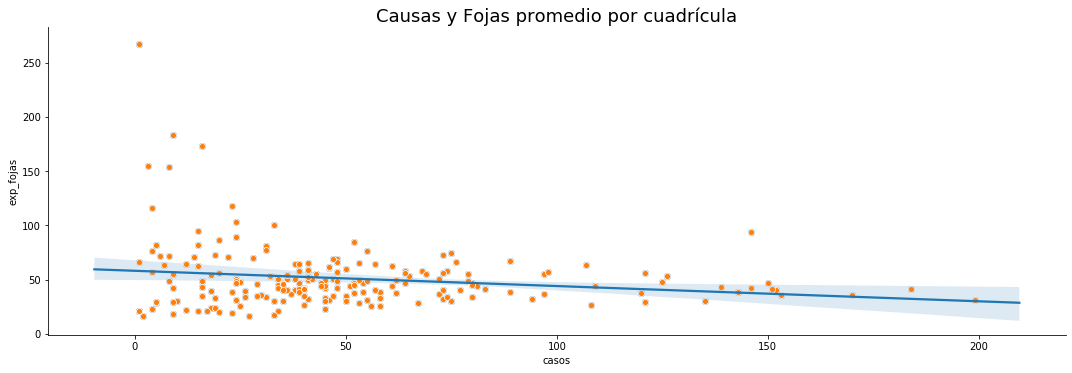

In [31]:
sns.lmplot('casos', 'exp_fojas', data=merge_df, height=5, aspect=3)
sns.scatterplot('casos', 'exp_fojas', data=merge_df)
plt.title('Causas y Fojas promedio por cuadrícula',size=18)
plt.show()

In [32]:
# Hagamos lo mismo excluyendo outliers
merge_df2 = merge_df[merge_df.exp_fojas < 150]
merge_df2[['exp_fojas','casos']].corr()

,exp_fojas,casos
exp_fojas,1.000000,-0.080651
casos,-0.080651,1.000000


In [33]:
results = pearsonr(merge_df2['exp_fojas'],merge_df2['casos'])
print(f'Coeficiente de correlación de Pearson: ',results[0])
p = results[1]
print(f'p-value: ',results[1])
if p < 0.05:
    print('Correlación significativa al 5%')

Coeficiente de correlación de Pearson:  -0.0806508613314849
p-value:  0.25990260613578786


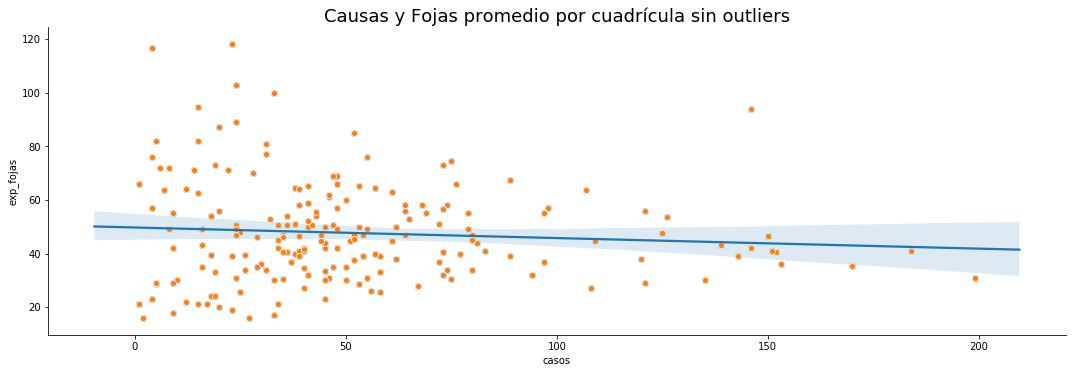

In [34]:
sns.lmplot('casos', 'exp_fojas', data=merge_df2, height=5, aspect=3)
sns.scatterplot('casos', 'exp_fojas', data=merge_df2)
plt.title('Causas y Fojas promedio por cuadrícula sin outliers',size=18)
plt.show()

Conclusión: hay una correlación negativa en general, pero explicada fundamentalmente por unas pocas zonas con muchas fojas promedio (que a su vez son zonas de relativamente pocas causas).

### Fojas totales por Zona geográfica

In [35]:
fojas_tot_geometry = geo_df_fojas.groupby('str_geometry').sum()['exp_fojas']
fojas_tot_geometry = fojas_tot_geometry.to_frame().reset_index(drop=False)
fojas_tot_geo_df = gpd.GeoDataFrame(fojas_tot_geometry['exp_fojas'], 
                                     geometry=fojas_tot_geometry['str_geometry'].apply(wkt.loads))
fojas_tot_geo_df.head()

,exp_fojas,geometry
0,461,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000..."
1,154,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000..."
2,192,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000..."
3,66,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000..."
4,141,"POLYGON ((-58.36000 -34.61000, -58.36000 -34.6..."


In [36]:
for i in range(fojas_tot_geo_df.shape[0]):
    fojas_tot_geo_df.at[i,'exp_fojas'] = int(fojas_tot_geo_df.at[i,'exp_fojas']/100)

In [37]:
fojas_tot_geo_df['coords'] = fojas_tot_geo_df['geometry'].apply(lambda x: x.representative_point().coords[:])
fojas_tot_geo_df['coords'] = [coords[0] for coords in fojas_tot_geo_df['coords']]
fojas_tot_geo_df.head()

,exp_fojas,geometry,coords
0,4,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000...","(-58.354294088366956, -34.62506061114897)"
1,1,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000...","(-58.35655385118322, -34.63466414848245)"
2,1,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000...","(-58.3697100558266, -34.65118001337335)"
3,0,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000...","(-58.394999999999996, -34.57686555016434)"
4,1,"POLYGON ((-58.36000 -34.61000, -58.36000 -34.6...","(-58.36765813123695, -34.61386353121595)"


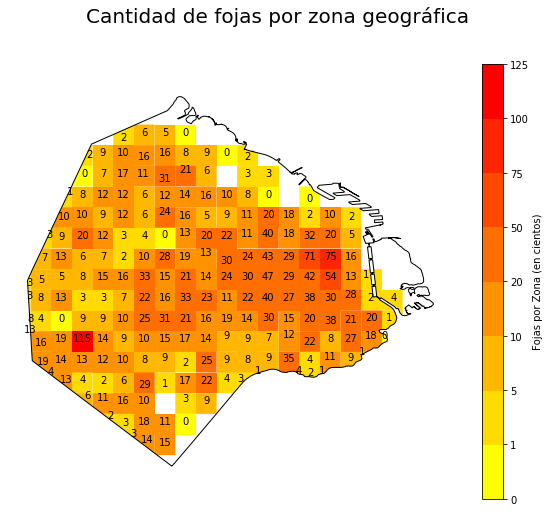

In [38]:
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.plot(linewidth=1, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
bounds = np.array([0,1,5,10,20,50,75,100,125,])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fojas_tot_geo_df.plot(ax=ax,column='exp_fojas',zorder=1,
                  legend=True,cmap='autumn_r',norm=norm,
                  legend_kwds={'label': "Fojas por Zona (en cientos)",})
# Labeleo el nombre a cada comuna
for idx, row in fojas_tot_geo_df.iterrows():
    plt.annotate(s=row['exp_fojas'], xy=row['coords'],
                 horizontalalignment='center')
fig.suptitle('Cantidad de fojas por zona geográfica',size=20)
ax.axis('off')
plt.show()

La distribución se asemeja a la de las causas, aunque es un poco más uniforme (fruto de la correlación negativa estudiada más arriba). Por otro lado, hay un interesante outlier que valdría la pena estudiar más en detalle. Finalmente, tener en cuenta que este mapa está contaminado por los NaNs de exp_fojas y que, en última instancia, como indicó el juez Casas, esta variable por sí sola no será un buen indicador de "carga de trabajo".

## Predictores de la distribución de causas

En este apartado exploramos algunas variables que pueden explicar la distribución geográfica de la densidad de causas.

### Población

El primer predictor a analizar es la población, siguiendo la intuición de que a más personas, más conflictos y en consecuencia más causas. Utilizamos información poblacional del Censo 2010 desagregada geográficamente por radio censal (datos de BA Data).  

In [39]:
censo_geodf = gpd.read_file('informacion_censal_por_radio_2010.shp')
censo_geodf.head()

,RADIO_I,BARRIO,COMUNA,POBLACI,VIVIEND,HOGARES,HOGARES_,AREA_KM,geometry
0,1_1_1,RETIRO,1,336.0,82.0,65.0,19.0,1.798997,"POLYGON ((-58.37189 -34.59199, -58.37202 -34.5..."
1,1_12_1,SAN NICOLAS,1,341.0,365.0,116.0,25.0,0.018565,"POLYGON ((-58.38593 -34.60444, -58.38575 -34.6..."
2,1_12_10,SAN NICOLAS,1,296.0,629.0,101.0,1.0,0.044380,"POLYGON ((-58.37879 -34.60528, -58.37741 -34.6..."
3,1_12_11,SAN NICOLAS,1,528.0,375.0,136.0,7.0,0.366340,"POLYGON ((-58.36733 -34.60562, -58.36713 -34.6..."
4,1_12_2,SAN NICOLAS,1,229.0,445.0,129.0,16.0,0.018363,"POLYGON ((-58.38454 -34.60436, -58.38311 -34.6..."


In [40]:
censo_geodf['Densidad'] = censo_geodf['POBLACI'] / censo_geodf['AREA_KM']

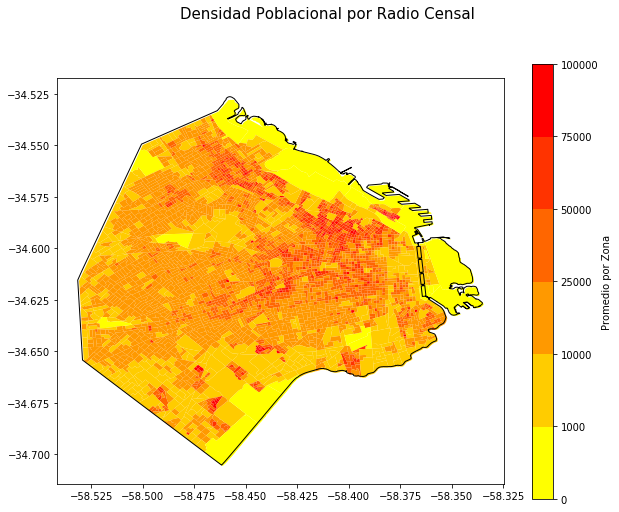

In [41]:
fig, ax = plt.subplots(1, figsize=(10, 8))
caba_df.plot(linewidth=1, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)

bounds = np.array([0, 1000, 10000, 25000, 50000, 75000, 100000])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
censo_geodf.plot(ax=ax,column='Densidad',zorder=1,
                legend=True,cmap='autumn_r',
                norm=norm,legend_kwds={'label': "Promedio por Zona",})
fig.suptitle('Densidad Poblacional por Radio Censal',size=15)
plt.show()

Parece haber una correlación con la cantidad de causas. Vamos a verlo en más detalle. Vamos a calcular la cantidad de personas que hay en cada una de las cuadrículas de nuestra grilla judicial. Para eso suponemos una distribución uniforme tanto de la población dentro de cada radio censal (supuesto que no es tan grave dado el tamaño relativamente pequeño de los radios censales) como de las causas dentro de cada cuadrícula (supuesto un poco más fuerte dado el tamaño de las cuadrículas pero inevitable con la información que tenemos).

In [42]:
# Interseccion radios censales y casos
import time
time0 = time.time()
casos_radiodf = casos_geo_df
for i in range(casos_radiodf.shape[0]):
    geometry_cuadrado = casos_radiodf.at[i,'geometry']
    poblacion = []
    for j in range(censo_geodf.shape[0]):
        polygon = censo_geodf.at[j,'geometry']
        area_polygon = polygon.area
        area_intersec = geometry_cuadrado.intersection(polygon).area
        poblacion_intersec = area_intersec*censo_geodf.at[j,'POBLACI'] / area_polygon
        poblacion.append(poblacion_intersec)
    casos_radiodf.at[i,'Poblacion'] = np.array(poblacion).sum()


print(f'Tardó: '+str(time.time()-time0))
casos_radiodf.head()

Tardó: 97.78976774215698


,casos,geometry,coords,Poblacion
0,199,"POLYGON ((-58.39000 -34.60000, -58.39000 -34.6...","(-58.394999999999996, -34.605000000000004)",33115.404760
1,184,"POLYGON ((-58.38000 -34.60000, -58.38000 -34.6...","(-58.385000000000005, -34.605000000000004)",16361.326489
2,170,"POLYGON ((-58.41000 -34.61000, -58.41000 -34.6...","(-58.41499999999999, -34.614999999999995)",33405.840046
3,153,"POLYGON ((-58.41000 -34.62000, -58.41000 -34.6...","(-58.41499999999999, -34.625)",21938.982845
4,152,"POLYGON ((-58.39000 -34.61000, -58.39000 -34.6...","(-58.394999999999996, -34.614999999999995)",35600.674060


In [43]:
# Chequeo
print(f'Poblacion Censo: '+str(censo_geodf['POBLACI'].sum()))
print(f'Polacion grilla: '+str(casos_radiodf['Poblacion'].sum()))

Poblacion Censo: 2890151.0
Polacion grilla: 2874299.6812284784


La diferencia se debe a que la grilla del dataset de causas no barre todo el área de la Ciudad de Buenos Aires. De todos modos a los efectos de nuestro análisis es suficiente.

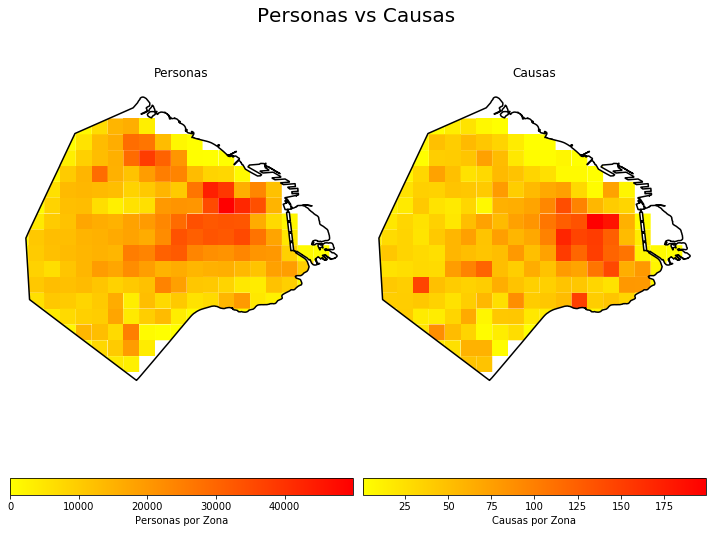

In [44]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
caba_df.boundary.plot(ax=ax[0],edgecolor='0')
caba_df.boundary.plot(ax=ax[1],edgecolor='0')
casos_radiodf.plot(ax=ax[0],column='Poblacion',
                   cmap='autumn_r',legend=True,
                  legend_kwds={'label': "Personas por Zona",
                               'orientation': "horizontal"})
casos_geo_df.plot(ax=ax[1],column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                  legend_kwds={'label': "Causas por Zona",
                              'orientation':'horizontal'})
ax[0].set_title('Personas')
ax[1].set_title('Causas')
ax[0].axis('off'),ax[1].axis('off')
plt.suptitle('Personas vs Causas',size=20)
plt.tight_layout()
plt.show()

In [45]:
print('Correlacion Causas y Poblacion')
casos_radiodf[['casos','Poblacion']].corr()

Correlacion Causas y Poblacion


,casos,Poblacion
casos,1.000000,0.594135
Poblacion,0.594135,1.000000


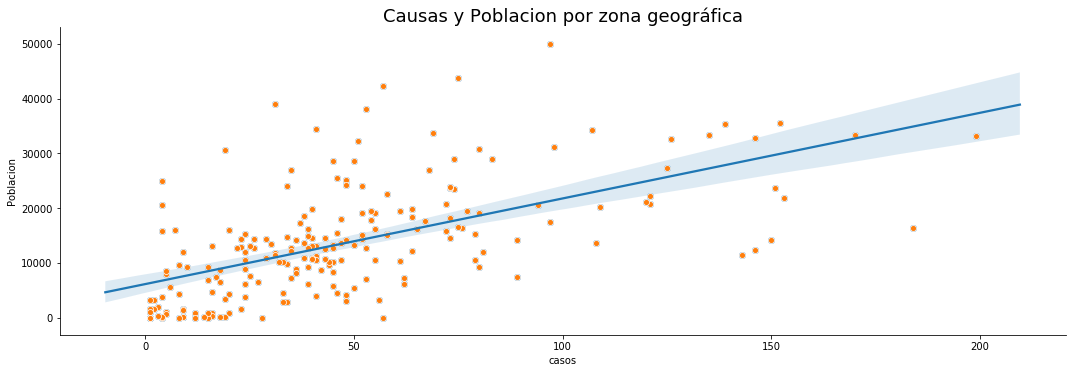

In [46]:
sns.lmplot('casos', 'Poblacion', data=casos_radiodf, height=5, aspect=3)
sns.scatterplot('casos', 'Poblacion', data=casos_radiodf)
plt.title('Causas y Poblacion por zona geográfica',size=18)
plt.show()

In [47]:
results = pearsonr(casos_radiodf['casos'],casos_radiodf['Poblacion'])
print(f'Coeficiente de correlación de Pearson: ',results[0])
p = results[1]
print(f'p-value: ',results[1])
if p < 0.05:
    print('Correlación significativa al 5%')

Coeficiente de correlación de Pearson:  0.5941354522275534
p-value:  1.990893542300773e-21
Correlación significativa al 5%


Idea: agregar feature de poblacion promedio en cuadrículas adyacentes.

### Densidad de tránsito

La otra variable disponible que podría explicar la cantidad de causas es la densidad de viajes en una zona determinada. Estoy pensando en conflictos que surgen no sólo entre residentes, que está contemplado en el apartado anterior, sino también en personas que se mueven a determinadas zonas por trabajo. En BA Data está la información de cantidad de viajes en subte por estación para poder hacer este análisis.

La procesé previamente en Excel para que queden los viajes entre las 16 y las 21 para el mes de enero de 2019 (una limitación en mi procesamiento del dataset, esto se puede cambiar). 

In [48]:
estaciones = pd.read_excel('viajes_enero2019.xlsx')
estaciones.head()

,Estacion,long,lat,Total Viajes,id,linea
0,9 de julio,-58.380574,-34.604245,187837,6,D
1,Acoyte,-58.436429,-34.618280,290410,42,A
2,Aguero,-58.407161,-34.591628,215771,9,D
3,Alberti,-58.401208,-34.609834,97569,37,A
4,Angel Gallardo,-58.431274,-34.602162,304612,28,B


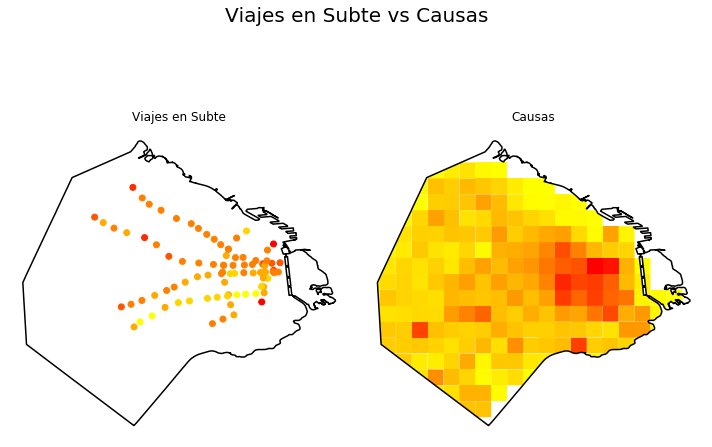

In [49]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
caba_df.boundary.plot(ax=ax[0],edgecolor='0')
caba_df.boundary.plot(ax=ax[1],edgecolor='0')
bounds = np.array([0,50000, 100000,200000,400000,600000,750000,1000000])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
ax[0].scatter(estaciones.long,estaciones.lat,
            c=estaciones['Total Viajes'],
           cmap='autumn_r',norm=norm,)

casos_geo_df.plot(ax=ax[1],column='casos',zorder=1,
                  cmap='autumn_r',)
ax[0].set_title('Viajes en Subte')
ax[1].set_title('Causas')
ax[0].axis('off'),ax[1].axis('off')
plt.suptitle('Viajes en Subte vs Causas',size=20)
plt.tight_layout()
plt.show()

Nota: parece haber correlación, habría que encontrar un feature adecuado para medir en cada cuadrícula. Es más complejo que en el caso anterior, porque se mezclan distancia con cantidad de viajes, además de que hay estaciones que son trasbordo (Retiro, Constitución, Lacroze, Congreso de Tucumán). Lo que me gustaría tener es una medida de cantidad de personas que trabajan en una zona determinada, y esta información del subte es una aproximación bastante ruidosa a esa idea. No es lo mismo densidad de tránsito que densidad de trabajo, digamos. Mi intuición es que los conflictos que dan lugar a causas judiciales ocurren más probablemente en aquellos lugares donde las personas permanecen durante un tiempo relativamente prolongado, y la densidad de tránsito no necesariamente captura eso. Necesitaría más bien data de los <b>destinos finales</b>. Por lo pronto, no estoy seguro de que aporte mucho más que la densidad poblacional.

La otra base interesante en esa dirección es la de Conteo de Peatones y de Conteo de Vehículos. Pero tienen muy pocas esquinas de la Ciudad para hacer una comparación interesante.

## Ideas para la distribución de causas

En este apartado exploramos algunas ideas para la distribución de causas en base a su distribución geográfica. Primero veamos donde están los dos edificios con juzgados.

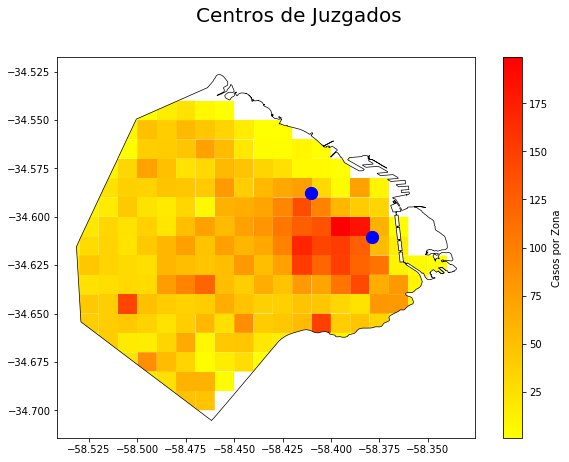

In [50]:
# Tacuari 198 = -34.610357, -58.378970
# Alto Palermo = -34.587686, -58.410279
fig, ax = plt.subplots(1, figsize=(10, 7))
caba_df.plot(linewidth=0.7, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                 legend_kwds={'label': "Casos por Zona",})
ax.scatter(x=[-58.378970,-58.410279],y=[-34.610357,-34.587686],s=150,c='blue')
fig.suptitle('Centros de Juzgados',size=20)
plt.show()

### Propuesta: decision boundary longitud, criterio casos

Propuesta 1: encontrar un decision boundary que divida a la Ciudad en dos, pasando "por el medio" de nuestros dos centros de Juzgados, de modo tal que la "carga de trabajo" a cada lado de la frontera sea igual. Empezamos por la propuesta más sencilla posible, sugerida por los centros de juzgados mismos: que el decision boundary sea una longitud (una línea horizontal). 

"Carga de trabajo" es un concepto que requiere elaboración, según lo conversado en la última reunión. Una idea básica para implementarlo es "cantidad de casos". Otras ideas giran en torno a cantidad de fojas, extensión de las resoluciones, gravedad de los delitos según el Código Penal. Para desarrollar estas otras cuestiones, habría que poder estimar estos valores con algún modelo en el momento de asignar las causas.

Por lo pronto, empezamos con "cantidad de casos", porque es un dato que tenemos y sobre el cual podríamos desarrollar matemáticamente la idea. Esta después sería extensible a otros conceptos de "carga de trabajo". 

In [51]:
lat_max = geo_df['den_latitud'].max()
lat_min = geo_df['den_latitud'].min()
lon_max = geo_df['den_longitud'].max()
lon_min = geo_df['den_longitud'].min()
x_set = np.linspace(lat_min,lat_max)
y_set = -34.6 + 0*x_set

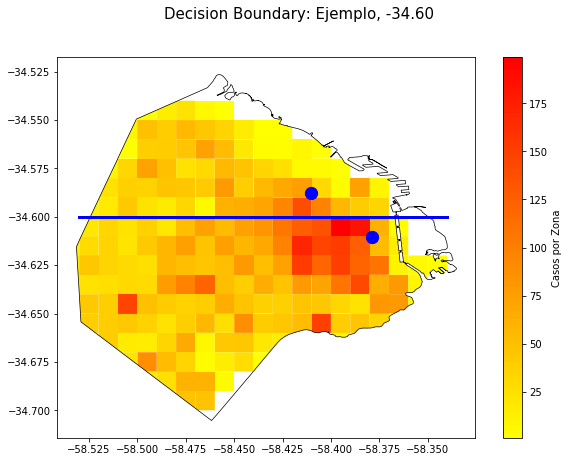

In [52]:
# Tacuari 198 = (-34.610357, -58.378970)
# Alto Palermo = (-34.587686, -58.410279)
fig, ax = plt.subplots(1, figsize=(10, 7))
caba_df.plot(linewidth=0.7, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                 legend_kwds={'label': "Casos por Zona",})
ax.scatter(x=[-58.378970,-58.410279],
           y=[-34.610357,-34.587686],
           s=150,c='blue')
ax.plot(x_set,y_set,c='blue',linewidth=3)
fig.suptitle('Decision Boundary: Ejemplo, -34.60',size=15)
plt.show()

Cómo elegimos la mejor longitud para hacer la separación? Será tal que la diferencia entre los casos al Norte y al Sur sea mínima. Nótese que el grado de imprecisión de los datos nos achica el espacio de búsqueda: iríamos desde -34.61 hasta -34.58 (longitudes de los centros de Juzgados). Podemos extendernos un poco más para tener más puntos de comparación.

In [53]:
def casos_longitud(longitud):
    casos_totales = geo_df.shape[0]
    casos_Norte = geo_df[geo_df.den_longitud >= longitud].shape[0]
    casos_Sur = casos_totales - casos_Norte
    return (casos_totales, casos_Norte, casos_Sur)

In [54]:
casos_df = pd.DataFrame()
longitudes = [-34.64 + i*0.01 for i in range(7)]
casos_df['longs'] = longitudes
for j in range(7):
    casos_df.at[j,'totales'] = casos_longitud(longitudes[j])[0]
    casos_df.at[j,'Norte'] = casos_longitud(longitudes[j])[1]
    casos_df.at[j,'Sur'] = casos_longitud(longitudes[j])[2]
    casos_df.at[j,'Dif'] = abs(casos_df.at[j,'Norte'] - casos_df.at[j,'Sur'])
casos_df

,longs,totales,Norte,Sur,Dif
0,-34.64,10100.0,8406.0,1694.0,6712.0
1,-34.63,10100.0,7451.0,2649.0,4802.0
2,-34.62,10100.0,6272.0,3828.0,2444.0
3,-34.61,10100.0,5036.0,5064.0,28.0
4,-34.60,10100.0,3747.0,6353.0,2606.0
5,-34.59,10100.0,2461.0,7639.0,5178.0
6,-34.58,10100.0,1648.0,8452.0,6804.0


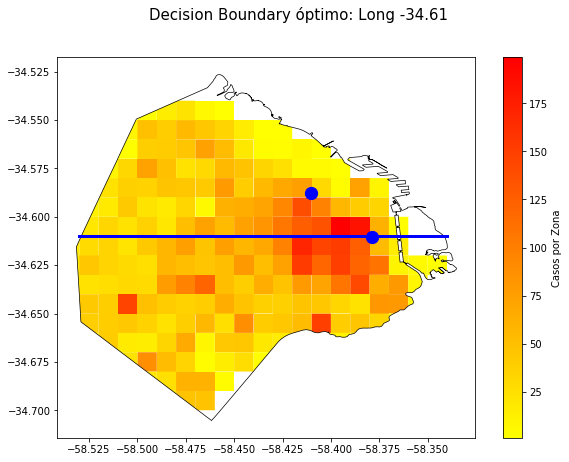

In [55]:
# Ploteamos el valor óptimo, i.e., el que minimiza la diferencia
minimo = casos_df['Dif'].min()
long_opt = float(casos_df[casos_df['Dif'] == minimo]['longs'].values)
y_set = long_opt + 0*x_set
fig, ax = plt.subplots(1, figsize=(10, 7))
caba_df.plot(linewidth=0.7, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r',
                 legend_kwds={'label': "Casos por Zona",})
ax.scatter(x=[-58.378970,-58.410279],y=[-34.610357,-34.587686],s=150,c='blue')
ax.plot(x_set,y_set,c='blue',linewidth=3)
fig.suptitle('Decision Boundary óptimo: Long '+str(long_opt),size=15)
plt.show()

### Propuesta: decision boundary longitud, criterio fojas

En este apartado, el mismo análisis pero tomando como función de "carga de trabajo" la cantidad de fojas (totales) por zona.

In [56]:
fojas_geometry = geo_df_pd.groupby('str_geometry').sum()['exp_fojas']
fojas_geometry = fojas_geometry.to_frame().reset_index(drop=False)
fojas_geo_df = gpd.GeoDataFrame(fojas_geometry['exp_fojas'],
                                geometry=fojas_geometry['str_geometry'].apply(wkt.loads))
fojas_geo_df.head()

,exp_fojas,geometry
0,462,"MULTIPOLYGON (((-58.35000 -34.62000, -58.35000..."
1,161,"MULTIPOLYGON (((-58.35000 -34.63000, -58.35000..."
2,193,"MULTIPOLYGON (((-58.37000 -34.65374, -58.37000..."
3,66,"MULTIPOLYGON (((-58.39000 -34.57000, -58.39000..."
4,1,"POLYGON ((-58.34000 -34.62000, -58.34000 -34.6..."


In [57]:
def fojas_longitud(longitud):
    fojas_totales = geo_df.exp_fojas.sum()
    fojas_Norte = geo_df[geo_df.den_longitud >= longitud].exp_fojas.sum()
    fojas_Sur = fojas_totales - fojas_Norte
    return (fojas_totales, fojas_Norte, fojas_Sur)

In [58]:
fojas_df = pd.DataFrame()
longitudes = [-34.64 + i*0.01 for i in range(7)]
fojas_df['longs'] = longitudes
for j in range(7):
    fojas_df.at[j,'totales'] = fojas_longitud(longitudes[j])[0]
    fojas_df.at[j,'Norte'] = fojas_longitud(longitudes[j])[1]
    fojas_df.at[j,'Sur'] = fojas_longitud(longitudes[j])[2]
    fojas_df.at[j,'Dif'] = abs(fojas_df.at[j,'Norte'] - fojas_df.at[j,'Sur'])
fojas_df

,longs,totales,Norte,Sur,Dif
0,-34.64,304009.0,257592.0,46417.0,211175.0
1,-34.63,304009.0,220661.0,83348.0,137313.0
2,-34.62,304009.0,187794.0,116215.0,71579.0
3,-34.61,304009.0,152799.0,151210.0,1589.0
4,-34.60,304009.0,113628.0,190381.0,76753.0
5,-34.59,304009.0,72643.0,231366.0,158723.0
6,-34.58,304009.0,48140.0,255869.0,207729.0


La longitud óptima en cantidad de casos y en fojas es la misma: -34.61

### Propuesta: Decision Boundary oblicuo

En este apartado investigamos la misma idea con una función lineal.

In [59]:
# calculo ordenada al origen
ordenada = -34.6 + 58.4

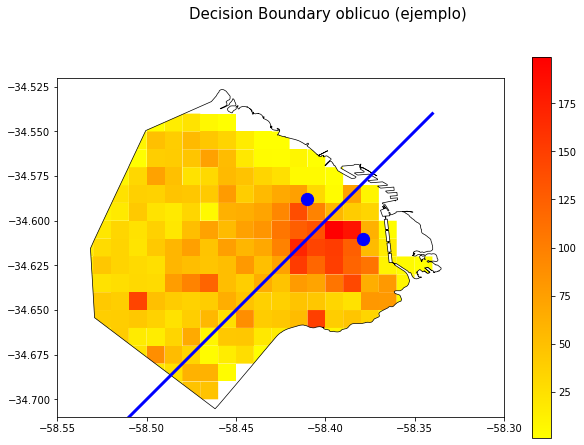

In [60]:
# Tacuari 198 = (-34.610357, -58.378970)
# Alto Palermo = (-34.587686, -58.410279)
y_set = ordenada + x_set
fig, ax = plt.subplots(1, figsize=(10, 7))
caba_df.plot(linewidth=0.7, ax=ax, edgecolor='0',
                facecolor='none',zorder=2)
casos_geo_df.plot(ax=ax,column='casos',zorder=1,
                  legend=True,cmap='autumn_r')
ax.scatter(x=[-58.378970,-58.410279],
           y=[-34.610357,-34.587686],
           s=150,c='blue')
ax.plot(x_set,y_set,c='blue',
        linewidth=3)
ax.set_xlim(-58.55,-58.30)
ax.set_ylim(-34.71,-34.52)
fig.suptitle('Decision Boundary oblicuo (ejemplo)',size=15)
plt.show()

<b>Pendiente</b>: elegir decision boundary lineal "óptimo" (qué sería óptimo?; tengo dos grados de libertad y un criterio).

### Propuesta: distribución por comunas

Dada la distribución administrativa de la Ciudad de Buenos Aires en Comunas, una posibilidad es establecer el decision boundary en función de esta división existente (de hecho, la distribución actual por Zonas hace uso de este criterio). Esta idea presenta algunas dificultades: la grilla sugerida por el truncamiento no estará geométricamente alineada con las Comunas, lo que dará lugar a una cierta ambigüedad para asignar causas a Comunas.

Empezamos por plotear las Comunas.

In [61]:
# Creamos polígonos de las Comunas 
# con la función unary union de Shapely
comunas = map_df.comuna.unique()
comunas_geometry = []
for comuna in comunas:
    barrios = [map_df.at[i,'geometry'] for i in range(map_df.shape[0]) if map_df.at[i,'comuna'] == comuna]
    geometry = unary_union(barrios)
    comunas_geometry.append(geometry)

comunas_df = gpd.GeoDataFrame()
comunas_df['Comuna'] = comunas
comunas_df['geometry'] = comunas_geometry
comunas_df.head()

,Comuna,geometry
0,15,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
1,11,"POLYGON ((-58.48192 -34.62429, -58.48274 -34.6..."
2,5,"POLYGON ((-58.41178 -34.63036, -58.41178 -34.6..."
3,6,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."
4,10,"POLYGON ((-58.48781 -34.64130, -58.48804 -34.6..."


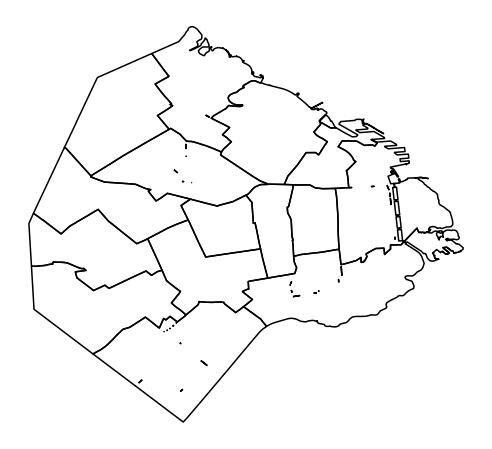

In [62]:
fig, ax = plt.subplots(1, figsize=(10, 8))
comunas_df.boundary.plot(ax=ax,edgecolor='0')
ax.axis('off')
plt.show()

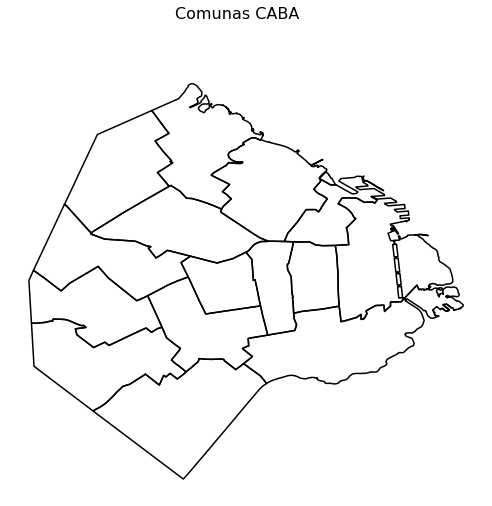

In [63]:
# Pequeña correcion a la geometría
epsilon = 10**(-12)
comunas_df['geometry'] = comunas_df['geometry'].map(lambda x:x.buffer(epsilon).buffer(-epsilon))
fig, ax = plt.subplots(1, figsize=(10, 8))
comunas_df.boundary.plot(ax=ax,edgecolor='0')
ax.axis('off')
fig.suptitle('Comunas CABA',fontsize=16)
plt.show()

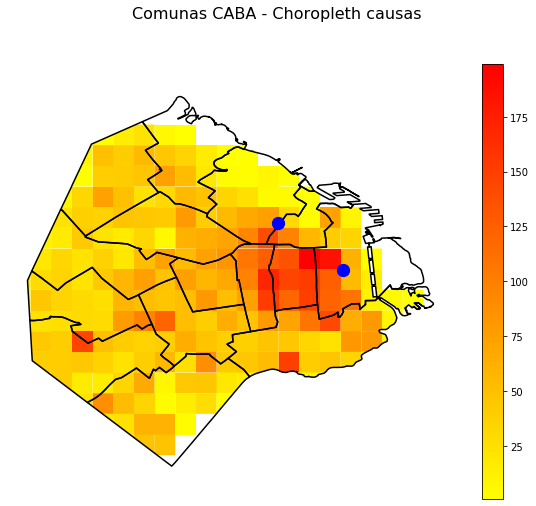

In [64]:
fig, ax = plt.subplots(1, figsize=(10, 8))
comunas_df.boundary.plot(ax=ax,edgecolor='0')
casos_geo_df.plot(ax=ax,column='casos',zorder=1,legend=True,cmap='autumn_r')
ax.scatter(x=[-58.378970,-58.410279],
           y=[-34.610357,-34.587686],
           s=150,c='blue',zorder=2)
ax.axis('off')
fig.suptitle('Comunas CABA - Choropleth causas',fontsize=16)
plt.show()

El resto del análisis de la distribución de causas por Comunas se lleva a cabo en el notebook correspondiente.

## Robustez de la distribución geográfica

Una cuestión importante a considerar es la representatividad de la distribución geográfica de causas que estamos considerando, teniendo en cuenta que la gran mayoría de las muestras carecen de coordenadas. Se me ocurren dos cuestiones a estudiar: por un lado, comparar este mapa de causas con el "Mapa del Delito" que confecciona la Ciudad de Buenos Aires. En ese caso son delitos denunciados en Comisarías, con lo cual habría que tomar en cuenta solamente aquellos que sean competencia de los Juzgados que estamos considerando (muchos no lo son, por lo que explicaba el juez Casas).

La otra cuestión tiene que ver con la cantidad de NaNs que tiene nuestro dataset en las coordenadas ("unknowns"). Una pregunta importante es si estós NaNs dependen de los valores de los otros features, en qué medida, y qué implica eso para las propuestas. Lo exploramos a continuación.

### Distribución de coordenadas NaNs por juzgado

In [65]:
df[df.org_cod_pri == 'JUZP01'].shape[0]

1094

In [66]:
df2 = df[df.org_cod_pri == 'JUZP01']
df2[df2.den_latitud == 'unknown'].shape[0]

0

In [67]:
algunos_juzgados = df.org_cod_pri.unique()[0:20]
juz_nans,juz_notnans = [],[]
juz_nans_prop,juz_notnans_prop = [],[]
for juzgado in algunos_juzgados:
    df_aux = df[df.org_cod_pri == juzgado]
    total = df_aux.shape[0]
    nans = df_aux[df_aux.den_latitud == 'unknown'].shape[0]
    juz_nans.append(nans)
    juz_notnans.append(total - nans)
    juz_nans_prop.append(nans/total)
    juz_notnans_prop.append((total-nans)/total)

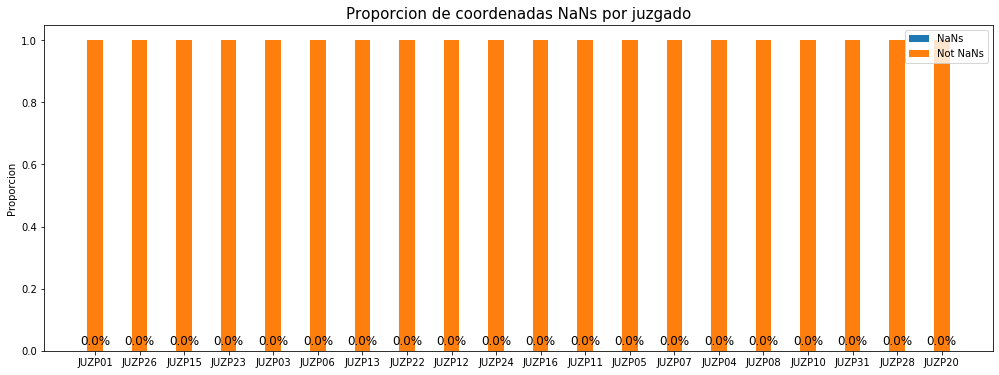

In [68]:
nan_prop = [juz_nans_prop[i] for i in range(len(juz_nans_prop))]
notnan_prop = [juz_notnans_prop[i] for i in range(len(juz_notnans_prop))]
width = 0.35
fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(algunos_juzgados, nan_prop, width, label='NaNs')
rects2 = ax.bar(algunos_juzgados, notnan_prop, width, bottom=nan_prop,
       label='Not NaNs')

for i in range(len(rects1)):
        height = rects1[i].get_height()
        porcentaje = round(nan_prop[i]*100,2)
        str_porc = str(porcentaje) + '%'
        ax.annotate('{}'.format(str_porc),
                    xy=(rects1[i].get_x() + rects1[i].get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                   size=12)

ax.set_ylabel('Proporcion')
ax.set_title('Proporcion de coordenadas NaNs por juzgado',size=15)
ax.legend()
plt.show()

In [69]:
from scipy.stats import chi2_contingency as chi2

juz_cont = pd.DataFrame(
    [
        juz_nans,
        juz_notnans,
    ],
    index=["NaNs","Not NaNs"],
    columns=algunos_juzgados)

juz_cont = juz_cont.transpose()
juz_cont.head()

,NaNs,Not NaNs
JUZP01,0,1094
JUZP26,0,1055
JUZP15,0,1290
JUZP23,0,1285
JUZP03,0,1730


In [70]:
chi2_results = chi2(juz_cont)
chi2_results

ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

In [ ]:
print(f'p-value: {chi2_results[1]}')
if chi2_results[1] < 0.05:
    print('Rechazo Ho de independencia')

### Distribución de coordenadas NaNs según causas

In [ ]:
# Listado de causas por frecuencia de ocurrencia
causas = df['oju_descr'].value_counts()
causas

In [ ]:
causas_frecuentes = causas.index[0:20]
causas_short = []
for i in range(20):
    causa_string = str(i)+' - '+causas.index[i][0:7]
    causas_short.append(causa_string)
causas_prop = []
for causa in causas_frecuentes:
    df_aux = df[df.oju_descr == causa]
    total = df_aux.shape[0]
    nans = df_aux[df_aux.den_latitud == 'unknown'].shape[0]
    proporciones = (nans / total,(total-nans) / total)
    causas_prop.append(proporciones)

In [ ]:
nan_prop = [causas_prop[i][0] for i in range(len(causas_prop))]
notnan_prop = [causas_prop[i][1] for i in range(len(causas_prop))]
width = 0.35
fig, ax = plt.subplots(figsize=(17,6))
rects1 = ax.bar(causas_short, nan_prop, width, label='NaNs')
rects2 = ax.bar(causas_short, notnan_prop, width, bottom=nan_prop,
       label='Not NaNs')

for i in range(len(rects1)):
        height = rects1[i].get_height()
        porcentaje = round(nan_prop[i]*100,2)
        str_porc = str(porcentaje) + '%'
        ax.annotate('{}'.format(str_porc),
                    xy=(rects1[i].get_x() + rects1[i].get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                   size=12)

for tick in ax.get_xticklabels():
        tick.set_rotation(45)

ax.set_ylabel('Proporcion')
ax.set_title('Proporcion de coordenadas NaNs por causa',size=15)
ax.legend()
plt.show()

Este es un panorama mucho más heterogéneo que habrá que estudiar en detalle para poder asignar las causas con un criterio razonable. Además de la heterogeneidad, es interesante la diferencia entre los dos primero delitos, cuya descripción es muy parecida (será que uno son amenazas teléfonicas / virtuales y el otro presenciales? - preguntar). 

## Comparación entre Zonas judiciales

### Mapa Zonas Judiciales

Recordamos que la zonificación de los juzgados de primera instancia, responde al siguiente mapeo de comunas (Resolución FG Nº 181-18)

Zona A: al Norte compuesto por las comunas 12, 13, 14, y 15;
Zona B: al Este compuesto por las comunas 1, 2, 3, y 5;
Zona C: al Sur compuesto por las comunas 4, 8, y 9;
Zona D: al Oeste compuesto por las comunas 6, 7, 10, y 11.

In [ ]:
def comuna_zona(comuna):
    if comuna in [12,13,14,15]:
        return 'A'
    elif comuna in [1,2,3,5]:
        return 'B'
    elif comuna in [4,8,9]:
        return 'C'
    else:
        return 'D'

In [ ]:
casos_comunasdf['Zona'] = casos_comunasdf['Comuna'].apply(lambda x: comuna_zona(float(x)))
casos_comunasdf[['Comuna','geometry','Zona','Casos']].head()

In [ ]:
# Creamos polígonos de las zonas judiciales 
zonas = ['A','B','C','D']
zona_geometry = []
zona_casos = []
for zona in zonas:
    comunas = [casos_comunasdf.at[i,'geometry'] \
               for i in range(casos_comunasdf.shape[0]) \
               if casos_comunasdf.at[i,'Zona'] == zona]
    geometry = unary_union(comunas)
    zona_geometry.append(geometry)
    casos = [casos_comunasdf.at[i,'Casos'] \
               for i in range(casos_comunasdf.shape[0]) \
               if casos_comunasdf.at[i,'Zona'] == zona]
    sum_casos = np.sum(np.array(casos))
    zona_casos.append(sum_casos)

zona_geodf = gpd.GeoDataFrame()
zona_geodf['Zona'] = zonas
zona_geodf['geometry'] = zona_geometry
# Pequeña correcion a la geometría
epsilon = 10**(-12)
zona_geodf['geometry'] = zona_geodf['geometry'].map(lambda x:x.buffer(epsilon).buffer(-epsilon))
zona_geodf['Casos'] = zona_casos
# esto es para los labels del mapa
zona_geodf['coords'] = zona_geodf['geometry'].apply(lambda x: x.representative_point().coords[:])
zona_geodf['coords'] = [coords[0] for coords in zona_geodf['coords']]
zona_geodf

In [ ]:
# Check
np.sum(zona_geodf.Casos)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))
zona_geodf.boundary.plot(ax=ax,edgecolor='0')
casos_geo_df.plot(ax=ax,column='casos',zorder=1,legend=True,cmap='autumn_r')
ax.axis('off')
# Labeleo el nombre a cada comuna
for idx, row in zona_geodf.iterrows():
    legend = 'Zona '+row['Zona']+' - '+str(int(row['Casos']))+' casos'
    plt.annotate(s=legend, xy=row['coords'],
                 horizontalalignment='center',
                fontsize=11,fontweight='bold')
fig.suptitle('Zonas Judiciales CABA',fontsize=16)
plt.show()

In [ ]:
time.time() - time_init